# **Assignment 2 - DL4NLP**

Assignment run on Google Colaboratory.

Answers to questions at the end of the notebook.

In [0]:
import numpy as np
import re
import tensorflow as tf
import datetime
import time
import matplotlib.pyplot as plt

In [0]:
import os
import urllib.request
urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.6B.zip', 'glove.zip')

('glove.zip', <http.client.HTTPMessage at 0x7fc327511b00>)

In [0]:
!unzip glove.zip

Archive:  glove.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
def glove_embedding(filename):
  file_glove=open(filename)
  glove={}
  for line in file_glove:
    tmp=line.split()
    word=tmp[0]
    coefficient=np.asarray(tmp[1:], dtype='float')
    glove[word]=coefficient

  file_glove.close()
  return glove


glove=glove_embedding('glove.6B.300d.txt')
print(len(glove))

400000


In [0]:
print(glove['chicago'])

In [0]:
!pip install -U -q PyDrive 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
#Used Google Drive to store the data files and called them using their URL ids
dataset=drive.CreateFile({'id':'1sZtg74UdDqF7ln8oQ9ML8yt5URJ9Y9M_'})
dataset.GetContentFile('datasetSentences.txt')

dataset=drive.CreateFile({'id':'1pOs1L-cPH4gGOEqxenc1gJmYXpNIWPwJ'})
dataset.GetContentFile('datasetSplit.txt')

dataset=drive.CreateFile({'id':'1R576Zcid3F-03yYrGM0PLVoIbUhMo8zD'})
dataset.GetContentFile('rt-polarity.pos')

dataset=drive.CreateFile({'id':'1ue-3QdyYisYT6gYDk4k6HU3HjTTK4k0B'})
dataset.GetContentFile('rt-polarity.neg')

In [0]:
def clean_str(string):
    """
    Tokenization/string cleaning 
    Function taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


In [0]:
file1="datasetSentences.txt"
read1 = list(open(file1, "r").readlines())
read1 = [s.strip() for s in read1]
x1 = [clean_str(sent) for sent in read1]
data=[]
for line in x1[1:]:
    tmp=line.split(" ",1)
    data.append([int(tmp[0]), tmp[1]])


file2 = "datasetSplit.txt"
read2 = list(open(file2, "r").readlines())
read2 = [s.strip() for s in read2]
#x2 = [clean_str(sent) for sent in read2]
data_split=[]
for line in read2[1:]:
    tmp=line.split(",")
    data_split.append([int(i) for i in tmp])



In [0]:
file3="rt-polarity.pos"
read3=list(open(file3,"r", encoding="latin-1").readlines())
read3=[s.strip() for s in read3]
x3=[clean_str(sent) for sent in read3]

file4="rt-polarity.neg"
read4=list(open(file4,"r",encoding="latin-1").readlines())
read4=[s.strip() for s in read4]
x4=[clean_str(sent) for sent in read4]

labels={}
for line in x3:
    tmp=line.split(".")
    for item in tmp:
        if len(item)>10:
            for i in range(len(data)):
                if item in data[i][1]:
                    labels[data[i][0]]=1


In [0]:
for line in x4:
  tmp=line.split(".")
  for item in tmp:
    if len(item)>10:
      for i in range(len(data)):
        if item in data[i][1]:
          labels[data[i][0]]=0

In [0]:
split={}
train,val,test=0,0,0
for k in labels.keys():
  split[k]=data_split[k-1][1]
  

In [0]:
x_text=[]
for key in labels.keys():
  x_text.append(data[key-1][1])
  
y=[]
for key in labels.keys():
  if labels[key]==1:
    y.append([0,1])

  else:
    y.append([1,0])
y=np.array(y)

In [0]:
class RNN:
    def __init__(self, sequence_length, num_classes, vocab_size, embedding_size,
                 cell_type, hidden_size, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_text = tf.placeholder(tf.int32, shape=[None, sequence_length], name='input_text')
        self.input_y = tf.placeholder(tf.float32, shape=[None, num_classes], name='input_y')
        self.dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')

        l2_loss = tf.constant(0.0)
        text_length = self._length(self.input_text)

        # Embedding layer
        with tf.device('/gpu:0'), tf.name_scope("text-embedding"):
            self.W_text = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W_text")
            self.embedded_chars = tf.nn.embedding_lookup(self.W_text, self.input_text)

        # Recurrent Neural Network
        with tf.name_scope("rnn"):
            cell = self._get_cell(hidden_size, cell_type)
            cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=self.dropout_keep_prob)
            all_outputs, _ = tf.nn.dynamic_rnn(cell=cell,
                                               inputs=self.embedded_chars,
                                               sequence_length=text_length,
                                               dtype=tf.float32)
            self.h_outputs = self.last_relevant(all_outputs, text_length)

        # Final scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable("W", shape=[hidden_size, num_classes], initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.logits = tf.nn.xw_plus_b(self.h_outputs, W, b, name="logits")
            self.predictions = tf.argmax(self.logits, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, axis=1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name="accuracy")

    @staticmethod
    def _get_cell(hidden_size, cell_type):
        if cell_type == "vanilla":
            return tf.nn.rnn_cell.BasicRNNCell(hidden_size)
        elif cell_type == "lstm":
            return tf.nn.rnn_cell.BasicLSTMCell(hidden_size)
        elif cell_type == "gru":
            return tf.nn.rnn_cell.GRUCell(hidden_size)
        else:
            print("ERROR: '" + cell_type + "' is a wrong cell type !!!")
            return None

    # Length of the sequence data
    @staticmethod
    def _length(seq):
        relevant = tf.sign(tf.abs(seq))
        length = tf.reduce_sum(relevant, reduction_indices=1)
        length = tf.cast(length, tf.int32)
        return length

    @staticmethod
    def last_relevant(seq, length):
        batch_size = tf.shape(seq)[0]
        max_length = int(seq.get_shape()[1])
        input_size = int(seq.get_shape()[2])
        index = tf.range(0, batch_size) * max_length + (length - 1)
        flat = tf.reshape(seq, [-1, input_size])
        return tf.gather(flat, index)

In [0]:
from keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 100000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

#create the word indices
tokenizer.fit_on_texts(x_text)

word_index = tokenizer.word_index





In [0]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)



# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")


FLAGS = tf.flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')
#FLAGS._parse_flags()
print("\nParameters:")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{} = {}".format(attr.upper(), value))
print("")


Parameters:
ALLOW_SOFT_PLACEMENT = <absl.flags._flag.BooleanFlag object at 0x7fc327fd94e0>
F = <absl.flags._flag.Flag object at 0x7fc327fcad30>
LOG_DEVICE_PLACEMENT = <absl.flags._flag.BooleanFlag object at 0x7fc327fd9438>



In [0]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data) - 1) / batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [0]:
def train(max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs,glove):
  
  loss_train=[]
  acc_train=[]
  loss_dev=[]
  acc_dev=[]
  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
  for word, i in word_index.items():
      embedding_vector = glove.get(word)
      if embedding_vector is not None:
         
          embedding_matrix[i] = embedding_vector

  
  text_vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sentence_length)
  x = np.array(list(text_vocab_processor.fit_transform(x_text)))
  print("Text Vocabulary Size: {:d}".format(len(text_vocab_processor.vocabulary_)))

  print("x = {0}".format(x.shape))
  print("y = {0}".format(y.shape))
  print("")
  x_train, x_dev, y_train, y_dev,x_eval,y_eval=[],[],[],[],[],[]
  cnt=0
  np.random.seed(10)
  shuffle_indices = np.random.permutation(np.arange(len(y)))
  x_shuffled = x[shuffle_indices]
  y_shuffled = y[shuffle_indices]

  for key in split.keys():
    if split[key]==1:
      x_train.append(x_shuffled[cnt])
      y_train.append(y_shuffled[cnt])
    elif split[key]==3:
      x_dev.append(x_shuffled[cnt])
      y_dev.append(y_shuffled[cnt])
    else:
      x_eval.append(x_shuffled[cnt])
      y_eval.append(y_shuffled[cnt])
    cnt+=1
  x_train=np.array(x_train)
  x_dev=np.array(x_dev)
  y_train=np.array(y_train)
  y_dev=np.array(y_dev)
  x_eval=np.array(x_eval)
  y_eval=np.array(y_eval)

  print("Train/Dev split: {:d}/{:d}\n".format(len(y_train), len(y_dev)))
  
  with tf.Graph().as_default():
      session_conf = tf.ConfigProto(
          allow_soft_placement=FLAGS.allow_soft_placement,
          log_device_placement=FLAGS.log_device_placement)
      sess = tf.Session(config=session_conf)
      with sess.as_default():
          rnn = RNN(
              sequence_length=x_train.shape[1],
              num_classes=y_train.shape[1],
              vocab_size=len(text_vocab_processor.vocabulary_),
              embedding_size=embedding_dim,
              cell_type=cell_type,
              hidden_size=hidden_size,
              l2_reg_lambda=l2_reg_lambda
          )

          # Define Training procedure
          global_step = tf.Variable(0, name="global_step", trainable=False)
          train_op = tf.train.AdamOptimizer(learning_rate).minimize(rnn.loss, global_step=global_step)
          loss_summary = tf.summary.scalar("loss", rnn.loss)
          acc_summary = tf.summary.scalar("accuracy", rnn.accuracy)
          train_summary_op = tf.summary.merge([loss_summary, acc_summary])
          
          # Initialize all variables
          sess.run(tf.global_variables_initializer())

          sess.run(rnn.W_text.assign(embedding_matrix))

          # Generate batches
          batches = batch_iter(
              list(zip(x_train, y_train)), batch_size, epochs)
          # Training loop. For each batch...
          for batch in batches:
              x_batch, y_batch = zip(*batch)
              # Train
              feed_dict = {
                  rnn.input_text: x_batch,
                  rnn.input_y: y_batch,
                  rnn.dropout_keep_prob: dropout
              }
              _, step, summaries, loss, accuracy = sess.run(
                  [train_op, global_step, train_summary_op, rnn.loss, rnn.accuracy], feed_dict)
              

              loss_train.append(loss)
              acc_train.append(accuracy)

              # Training log display
              if step % 10 == 0:
                  time_str = datetime.datetime.now().isoformat()
                  print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))

              # Evaluation
              if step % int(train_size/batch_size) == 0:
                  print("\nEvaluation:")
                  feed_dict_dev = {
                      rnn.input_text: x_dev,
                      rnn.input_y: y_dev,
                      rnn.dropout_keep_prob: dropout
                  }
                  dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
                  summaries_dev, loss, accuracy = sess.run(
                      [dev_summary_op, rnn.loss, rnn.accuracy], feed_dict_dev)
                  

                  time_str = datetime.datetime.now().isoformat()
                  
                  loss_dev.append(loss)
                  acc_dev.append(accuracy)
                  print("{}: step {}, loss {:g}, acc {:g}\n".format(time_str, step, loss, accuracy))
                  
          for op in tf.get_default_graph().get_operations():
            #print(str(op.name))
            if str(op.name)=="input_text":
              input_text=op.outputs[0]
              print(input_text)
            elif str(op.name)=="dropout_keep_prob":
              dropout_keep_prob=op.outputs[0]
              print(dropout_keep_prob)
            elif str(op.name)=="output/predictions":
              predictions=op.outputs[0]
              print(predictions)
          batches = batch_iter(list(x_eval),batch_size, 1, shuffle=False)

          all_predictions=[]
          for x_batch in batches:
              batch_predictions = sess.run(predictions, {input_text: x_batch,
                                                         dropout_keep_prob: dropout})
              all_predictions = np.concatenate([all_predictions, batch_predictions])

          correct_predictions=0.0
          for i in range(len(y_eval)):
            if y_eval[i][1]==all_predictions[i]:
              correct_predictions+=1
              
          print("Total number of test examples: {}".format(len(y_eval)))
          print("Accuracy: {:g}".format(correct_predictions / float(len(y_eval))))
         
  return loss_train, loss_dev, acc_train, acc_dev




Using Glove 300

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,300,"vanilla", 64,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T03:58:48.661733: step 10, loss 3.16162, acc 0.421875
2019-10-26T03:58:49.217116: step 20, loss 1.23563, acc 0.515625
2019-10-26T03:58:49.753808: step 30, loss 0.801417, acc 0.453125
2019-10-26T03:58:50.297555: step 40, loss 0.733075, acc 0.53125
2019-10-26T03:58:50.864328: step 50, loss 0.717809, acc 0.578125
2019-10-26T03:58:51.420121: step 60, loss 0.711095, acc 0.421875
2019-10-26T03:58:51.991722: step 70, loss 0.69381, acc 0.546875
2019-10-26T03:58:52.548009: step 80, loss 0.688698, acc 0.59375
2019-10-26T03:58:53.094089: step 90, loss 0.691044, acc 0.59375
2019-10-26T03:58:53.630563: step 100, loss 0.708309, acc 0.5

Evaluation:
2019-10-26T03:58:54.097853: step 106, loss 0.69627, acc 0.547592

2019-10-26T03:58:54.308307: step 110, loss 0.70915, acc 0.546875
2019-10-26T03:58:54.856089: step 120, loss 0.648541, acc 0.6875
2019-10-26T03:58:55.412817: step 130, loss 0.682345, acc 0.578125


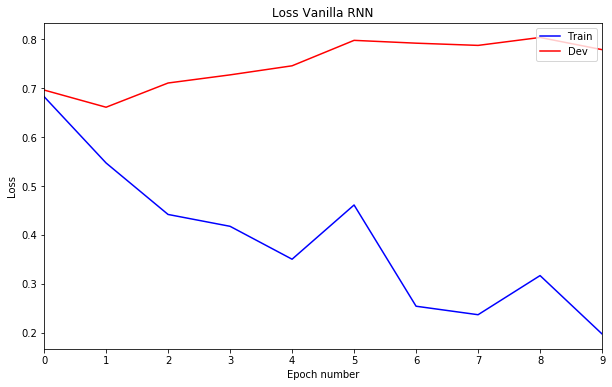

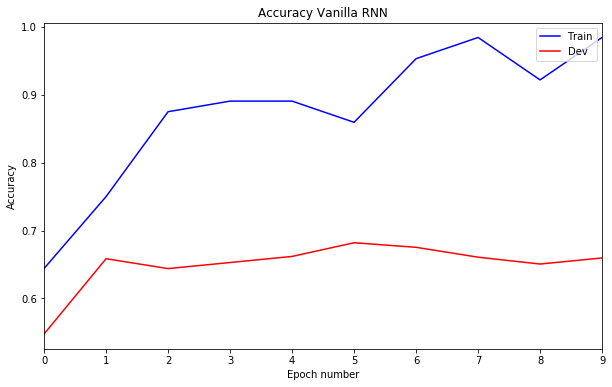

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,300,"lstm", 64,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:00:31.203011: step 10, loss 2.99086, acc 0.4375
2019-10-26T04:00:31.940181: step 20, loss 1.18279, acc 0.5
2019-10-26T04:00:32.626100: step 30, loss 0.768013, acc 0.390625
2019-10-26T04:00:33.341390: step 40, loss 0.731041, acc 0.46875
2019-10-26T04:00:34.051537: step 50, loss 0.715046, acc 0.578125
2019-10-26T04:00:34.767154: step 60, loss 0.702387, acc 0.40625
2019-10-26T04:00:35.495933: step 70, loss 0.697494, acc 0.515625
2019-10-26T04:00:36.223221: step 80, loss 0.683411, acc 0.71875
2019-10-26T04:00:36.945578: step 90, loss 0.700412, acc 0.484375
2019-10-26T04:00:37.632730: step 100, loss 0.702816, acc 0.609375

Evaluation:
2019-10-26T04:00:38.217232: step 106, loss 0.670888, acc 0.680851

2019-10-26T04:00:38.488114: step 110, loss 0.618798, acc 0.78125
2019-10-26T04:00:39.198947: step 120, loss 0.633912, acc 0.78125
2019-10-26T04:00:39.918761: step 130, loss 0.589544, acc 0.875
20

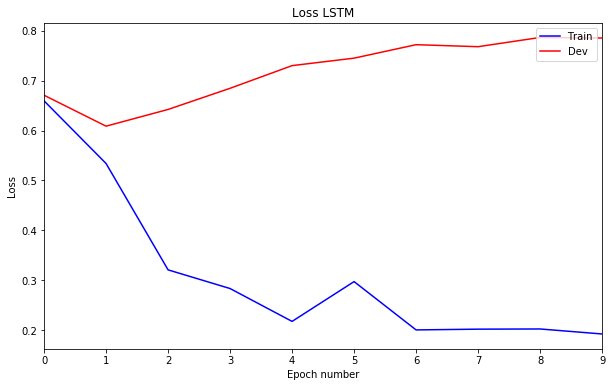

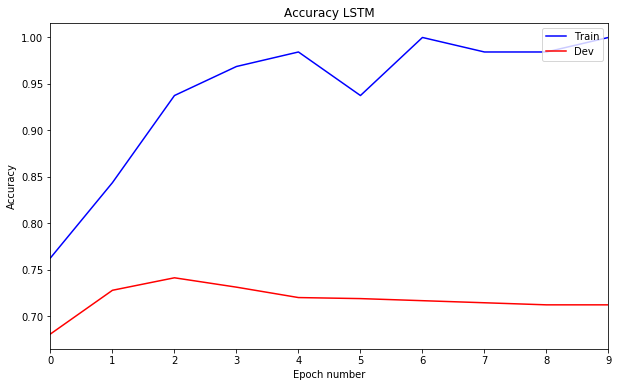

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss LSTM')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()


fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy LSTM')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,300,"gru", 64,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:01:52.758176: step 10, loss 3.00752, acc 0.421875
2019-10-26T04:01:53.498829: step 20, loss 1.17515, acc 0.546875
2019-10-26T04:01:54.182547: step 30, loss 0.764854, acc 0.59375
2019-10-26T04:01:54.882560: step 40, loss 0.725125, acc 0.546875
2019-10-26T04:01:55.614194: step 50, loss 0.6948, acc 0.65625
2019-10-26T04:01:56.345380: step 60, loss 0.658071, acc 0.71875
2019-10-26T04:01:57.076756: step 70, loss 0.668687, acc 0.65625
2019-10-26T04:01:57.804310: step 80, loss 0.652801, acc 0.671875
2019-10-26T04:01:58.527462: step 90, loss 0.703584, acc 0.53125
2019-10-26T04:01:59.204363: step 100, loss 0.684258, acc 0.59375

Evaluation:
2019-10-26T04:01:59.785436: step 106, loss 0.651025, acc 0.705487

2019-10-26T04:02:00.054752: step 110, loss 0.567089, acc 0.84375
2019-10-26T04:02:00.778246: step 120, loss 0.347409, acc 0.921875
2019-10-26T04:02:01.505013: step 130, loss 0.419148, acc 0.921

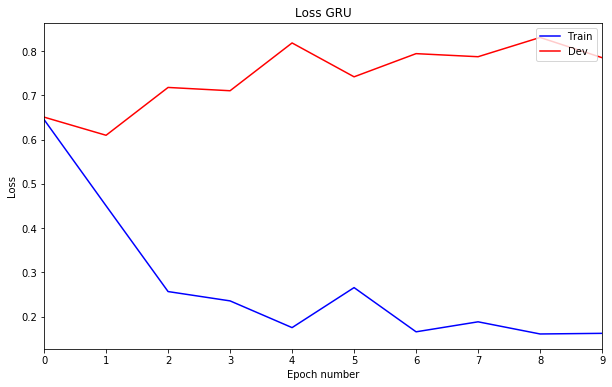

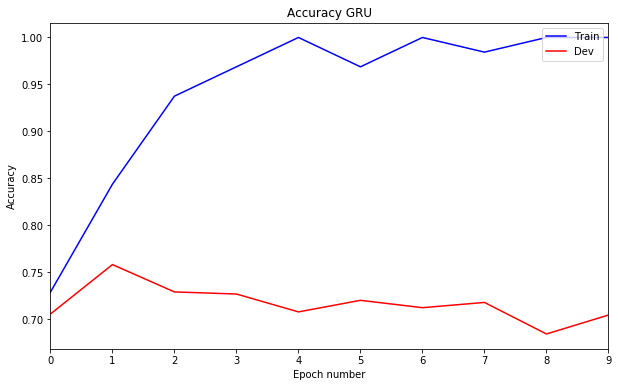

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss GRU')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()


fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy GRU')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

Changing hidden units to 128 and 32

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,300,"vanilla", 128,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:04:47.607242: step 10, loss 2.17499, acc 0.515625
2019-10-26T04:04:48.178798: step 20, loss 0.840873, acc 0.421875
2019-10-26T04:04:48.737490: step 30, loss 0.880845, acc 0.421875
2019-10-26T04:04:49.312495: step 40, loss 0.744662, acc 0.5625
2019-10-26T04:04:49.870532: step 50, loss 0.770009, acc 0.390625
2019-10-26T04:04:50.444757: step 60, loss 0.733288, acc 0.5625
2019-10-26T04:04:51.007768: step 70, loss 0.722913, acc 0.515625
2019-10-26T04:04:51.579531: step 80, loss 0.714958, acc 0.484375
2019-10-26T04:04:52.146992: step 90, loss 0.759142, acc 0.46875
2019-10-26T04:04:52.688780: step 100, loss 0.699624, acc 0.53125

Evaluation:
2019-10-26T04:04:53.173331: step 106, loss 0.714433, acc 0.5028

2019-10-26T04:04:53.398536: step 110, loss 0.881473, acc 0.375
2019-10-26T04:04:53.960548: step 120, loss 0.71351, acc 0.5
2019-10-26T04:04:54.543190: step 130, loss 0.738216, acc 0.5
2019-10-

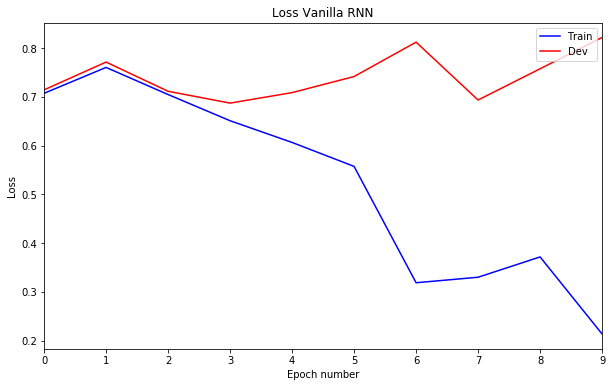

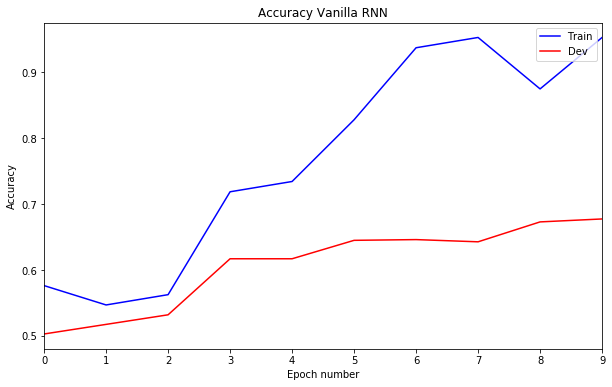

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,300,"lstm", 128,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:06:21.156488: step 10, loss 2.09755, acc 0.5
2019-10-26T04:06:21.915777: step 20, loss 0.845051, acc 0.484375
2019-10-26T04:06:22.636132: step 30, loss 0.81346, acc 0.390625
2019-10-26T04:06:23.365226: step 40, loss 0.749988, acc 0.5625
2019-10-26T04:06:24.135136: step 50, loss 0.704189, acc 0.609375
2019-10-26T04:06:24.882026: step 60, loss 0.701019, acc 0.453125
2019-10-26T04:06:25.634264: step 70, loss 0.701962, acc 0.421875
2019-10-26T04:06:26.371527: step 80, loss 0.691956, acc 0.609375
2019-10-26T04:06:27.125769: step 90, loss 0.695482, acc 0.5
2019-10-26T04:06:27.838842: step 100, loss 0.693372, acc 0.53125

Evaluation:
2019-10-26T04:06:28.437253: step 106, loss 0.695541, acc 0.490482

2019-10-26T04:06:28.733105: step 110, loss 0.691906, acc 0.5625
2019-10-26T04:06:29.480123: step 120, loss 0.682196, acc 0.734375
2019-10-26T04:06:30.238556: step 130, loss 0.679022, acc 0.640625
20

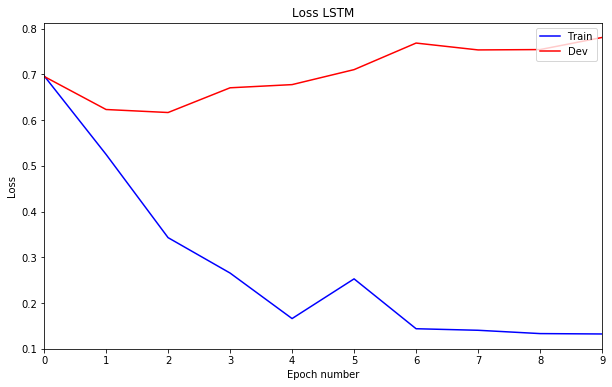

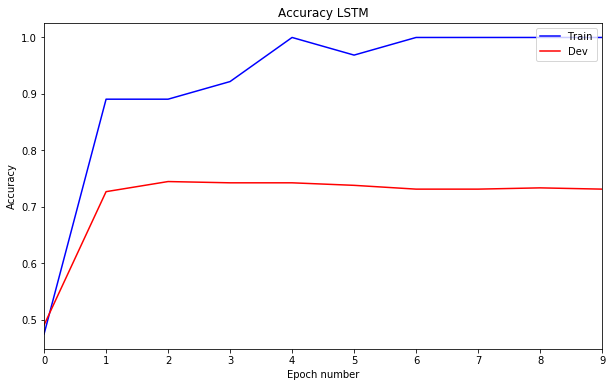

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss LSTM')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy LSTM')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,300,"gru", 128,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:07:46.062782: step 10, loss 2.12581, acc 0.546875
2019-10-26T04:07:46.828653: step 20, loss 0.822649, acc 0.578125
2019-10-26T04:07:47.552353: step 30, loss 0.829172, acc 0.390625
2019-10-26T04:07:48.284345: step 40, loss 0.75686, acc 0.484375
2019-10-26T04:07:49.026307: step 50, loss 0.69132, acc 0.625
2019-10-26T04:07:49.756702: step 60, loss 0.70195, acc 0.59375
2019-10-26T04:07:50.521199: step 70, loss 0.636813, acc 0.765625
2019-10-26T04:07:51.272682: step 80, loss 0.591771, acc 0.734375
2019-10-26T04:07:52.019364: step 90, loss 0.623724, acc 0.71875
2019-10-26T04:07:52.738214: step 100, loss 0.622405, acc 0.640625

Evaluation:
2019-10-26T04:07:53.356942: step 106, loss 0.598073, acc 0.741321

2019-10-26T04:07:53.641071: step 110, loss 0.481185, acc 0.859375
2019-10-26T04:07:54.384707: step 120, loss 0.364569, acc 0.921875
2019-10-26T04:07:55.128671: step 130, loss 0.408866, acc 0.8

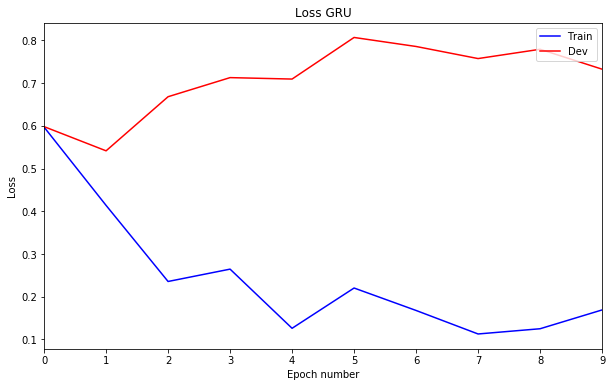

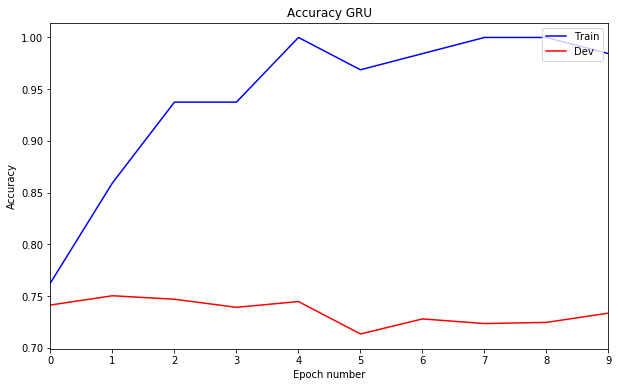

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss GRU')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy GRU')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,300,"vanilla", 32,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:09:10.795081: step 10, loss 3.51354, acc 0.484375
2019-10-26T04:09:11.361709: step 20, loss 1.82283, acc 0.453125
2019-10-26T04:09:11.884670: step 30, loss 1.00181, acc 0.5625
2019-10-26T04:09:12.447794: step 40, loss 0.760892, acc 0.609375
2019-10-26T04:09:13.017022: step 50, loss 0.711936, acc 0.53125
2019-10-26T04:09:13.570658: step 60, loss 0.698047, acc 0.53125
2019-10-26T04:09:14.146625: step 70, loss 0.70128, acc 0.5
2019-10-26T04:09:14.689672: step 80, loss 0.696405, acc 0.484375
2019-10-26T04:09:15.260869: step 90, loss 0.694358, acc 0.5
2019-10-26T04:09:15.781473: step 100, loss 0.695621, acc 0.546875

Evaluation:
2019-10-26T04:09:16.253011: step 106, loss 0.693087, acc 0.549832

2019-10-26T04:09:16.462516: step 110, loss 0.669489, acc 0.6875
2019-10-26T04:09:17.004205: step 120, loss 0.606736, acc 0.796875
2019-10-26T04:09:17.574214: step 130, loss 0.708736, acc 0.59375
2019-1

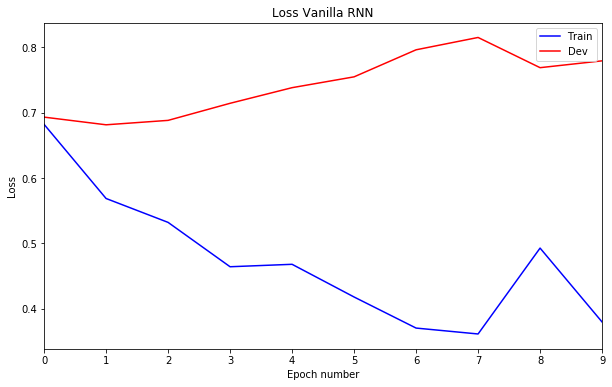

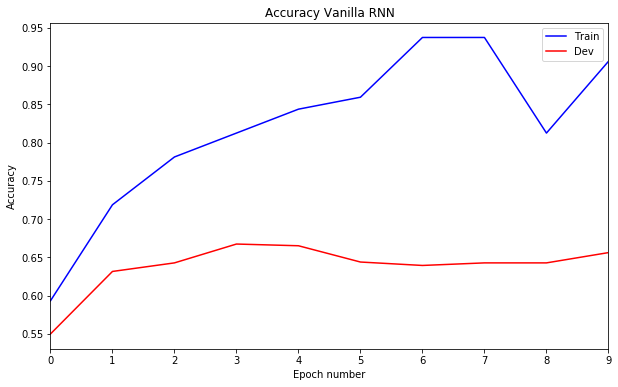

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,300,"lstm", 32,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:10:15.756675: step 10, loss 3.07936, acc 0.65625
2019-10-26T04:10:16.475694: step 20, loss 1.58124, acc 0.609375
2019-10-26T04:10:17.157518: step 30, loss 0.972221, acc 0.65625
2019-10-26T04:10:17.847444: step 40, loss 0.753413, acc 0.65625
2019-10-26T04:10:18.548317: step 50, loss 0.69598, acc 0.65625
2019-10-26T04:10:19.244842: step 60, loss 0.69926, acc 0.609375
2019-10-26T04:10:19.958810: step 70, loss 0.661045, acc 0.734375
2019-10-26T04:10:20.659554: step 80, loss 0.654459, acc 0.75
2019-10-26T04:10:21.370298: step 90, loss 0.654207, acc 0.75
2019-10-26T04:10:22.042800: step 100, loss 0.681831, acc 0.671875

Evaluation:
2019-10-26T04:10:22.602424: step 106, loss 0.636163, acc 0.716685

2019-10-26T04:10:22.888400: step 110, loss 0.563174, acc 0.828125
2019-10-26T04:10:23.606282: step 120, loss 0.565831, acc 0.796875
2019-10-26T04:10:24.328138: step 130, loss 0.482828, acc 0.890625
2

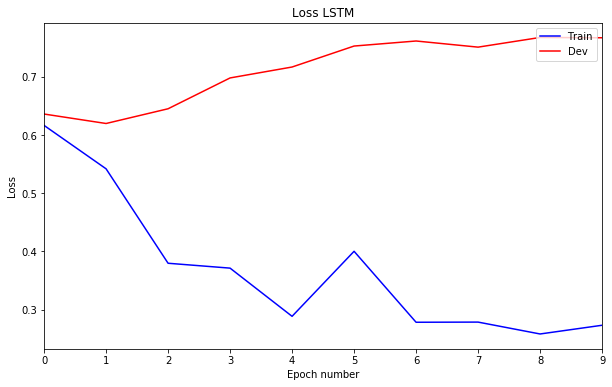

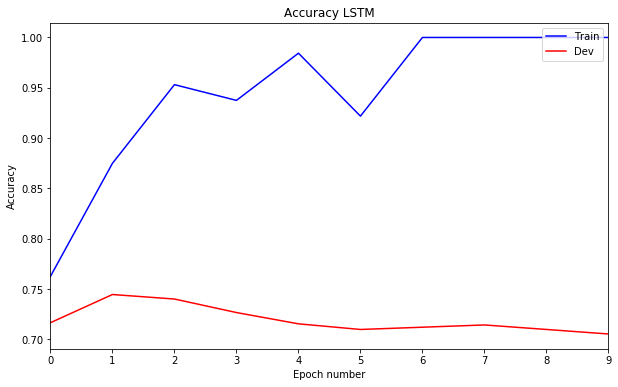

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss LSTM')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy LSTM')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,300,"gru", 32,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:11:36.304267: step 10, loss 3.52631, acc 0.4375
2019-10-26T04:11:37.043108: step 20, loss 1.71288, acc 0.609375
2019-10-26T04:11:37.706972: step 30, loss 1.02392, acc 0.421875
2019-10-26T04:11:38.408398: step 40, loss 0.745558, acc 0.703125
2019-10-26T04:11:39.108122: step 50, loss 0.679436, acc 0.6875
2019-10-26T04:11:39.826062: step 60, loss 0.691739, acc 0.578125
2019-10-26T04:11:40.539107: step 70, loss 0.626708, acc 0.734375
2019-10-26T04:11:41.247695: step 80, loss 0.543093, acc 0.84375
2019-10-26T04:11:41.946424: step 90, loss 0.661114, acc 0.640625
2019-10-26T04:11:42.624804: step 100, loss 0.613779, acc 0.765625

Evaluation:
2019-10-26T04:11:43.191780: step 106, loss 0.597404, acc 0.74804

2019-10-26T04:11:43.465388: step 110, loss 0.474646, acc 0.9375
2019-10-26T04:11:44.147791: step 120, loss 0.373652, acc 0.9375
2019-10-26T04:11:44.853591: step 130, loss 0.48291, acc 0.84375


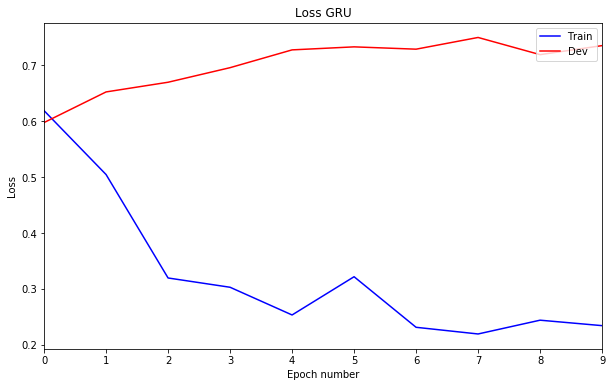

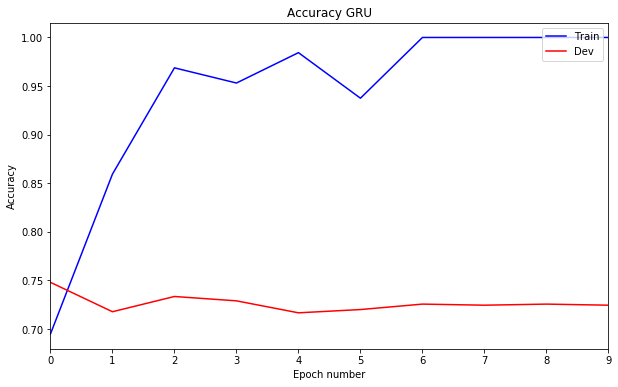

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss GRU')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy GRU')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

Making sequence length to 200 and 50

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(200,300,"vanilla", 32,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 200)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:12:56.379901: step 10, loss 3.74648, acc 0.546875
2019-10-26T04:12:56.979813: step 20, loss 1.83035, acc 0.46875
2019-10-26T04:12:57.558645: step 30, loss 1.06459, acc 0.390625
2019-10-26T04:12:58.143912: step 40, loss 0.76502, acc 0.515625
2019-10-26T04:12:58.749253: step 50, loss 0.715992, acc 0.4375
2019-10-26T04:12:59.373819: step 60, loss 0.70238, acc 0.46875
2019-10-26T04:12:59.963687: step 70, loss 0.696252, acc 0.453125
2019-10-26T04:13:00.561495: step 80, loss 0.699052, acc 0.484375
2019-10-26T04:13:01.149408: step 90, loss 0.688566, acc 0.59375
2019-10-26T04:13:01.717276: step 100, loss 0.683428, acc 0.65625

Evaluation:
2019-10-26T04:13:02.218805: step 106, loss 0.691649, acc 0.56103

2019-10-26T04:13:02.446173: step 110, loss 0.673795, acc 0.6875
2019-10-26T04:13:03.032601: step 120, loss 0.604497, acc 0.828125
2019-10-26T04:13:03.631118: step 130, loss 0.677406, acc 0.65625


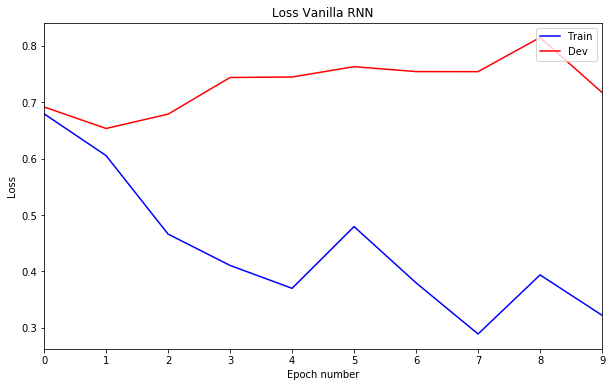

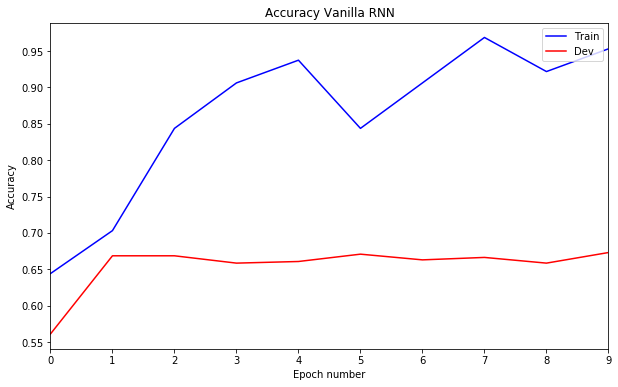

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(200,300,"lstm", 32,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 200)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:14:05.453798: step 10, loss 3.59957, acc 0.5625
2019-10-26T04:14:06.208753: step 20, loss 1.79521, acc 0.578125
2019-10-26T04:14:06.917657: step 30, loss 1.03047, acc 0.59375
2019-10-26T04:14:07.654471: step 40, loss 0.771782, acc 0.578125
2019-10-26T04:14:08.402440: step 50, loss 0.704491, acc 0.671875
2019-10-26T04:14:09.142277: step 60, loss 0.697939, acc 0.46875
2019-10-26T04:14:09.880432: step 70, loss 0.685328, acc 0.71875
2019-10-26T04:14:10.628959: step 80, loss 0.663989, acc 0.75
2019-10-26T04:14:11.380730: step 90, loss 0.66175, acc 0.78125
2019-10-26T04:14:12.102048: step 100, loss 0.66193, acc 0.6875

Evaluation:
2019-10-26T04:14:12.694603: step 106, loss 0.649866, acc 0.732363

2019-10-26T04:14:12.976646: step 110, loss 0.604055, acc 0.8125
2019-10-26T04:14:13.708889: step 120, loss 0.559315, acc 0.84375
2019-10-26T04:14:14.445809: step 130, loss 0.526847, acc 0.890625
2019-

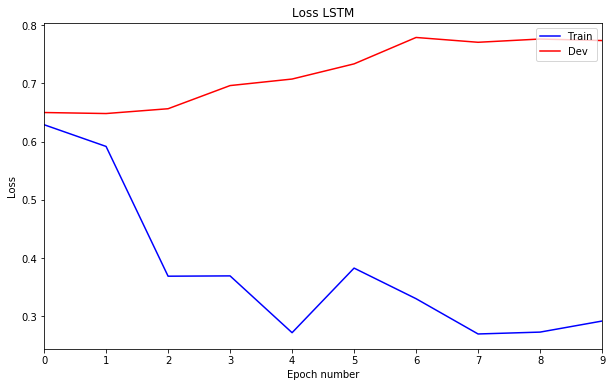

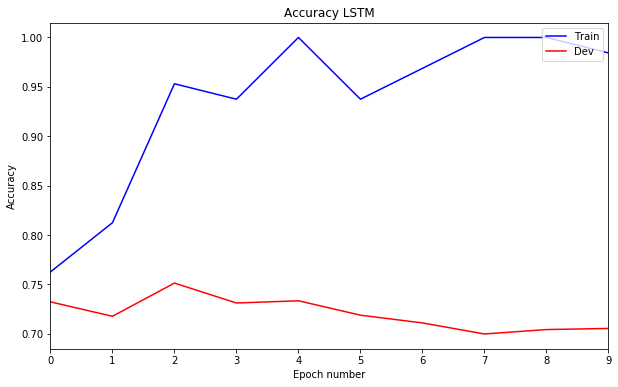

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss LSTM')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy LSTM')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(200,300,"gru", 32,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 200)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:15:29.944880: step 10, loss 3.30829, acc 0.59375
2019-10-26T04:15:30.701235: step 20, loss 1.64633, acc 0.5
2019-10-26T04:15:31.416361: step 30, loss 0.993704, acc 0.46875
2019-10-26T04:15:32.159338: step 40, loss 0.750157, acc 0.6875
2019-10-26T04:15:32.906248: step 50, loss 0.681612, acc 0.703125
2019-10-26T04:15:33.659400: step 60, loss 0.673822, acc 0.65625
2019-10-26T04:15:34.396501: step 70, loss 0.642707, acc 0.671875
2019-10-26T04:15:35.125333: step 80, loss 0.571544, acc 0.8125
2019-10-26T04:15:35.890473: step 90, loss 0.646922, acc 0.71875
2019-10-26T04:15:36.607306: step 100, loss 0.629866, acc 0.734375

Evaluation:
2019-10-26T04:15:37.197086: step 106, loss 0.599176, acc 0.744681

2019-10-26T04:15:37.486073: step 110, loss 0.452401, acc 0.921875
2019-10-26T04:15:38.218056: step 120, loss 0.362339, acc 0.921875
2019-10-26T04:15:38.968752: step 130, loss 0.445361, acc 0.890625


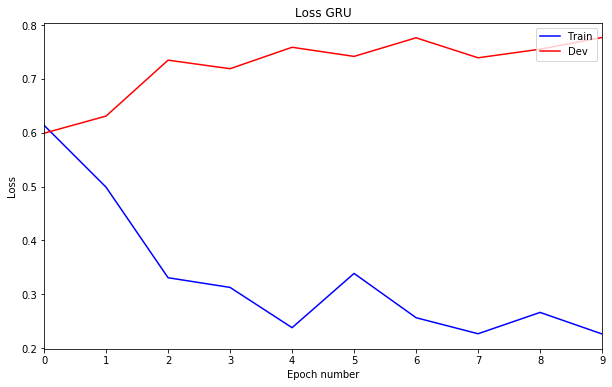

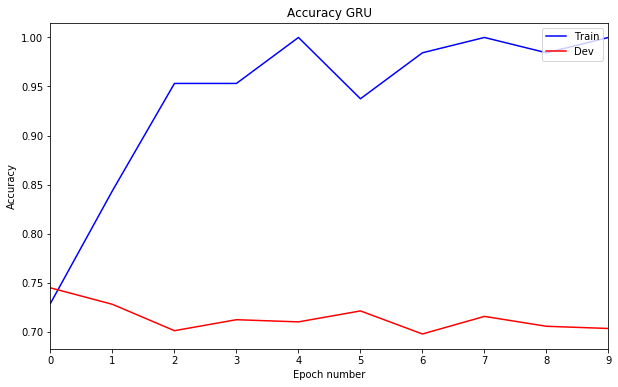

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss GRU')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy GRU')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(50,300,"vanilla", 32,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 50)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:16:54.061456: step 10, loss 3.4959, acc 0.4375
2019-10-26T04:16:54.592908: step 20, loss 1.57795, acc 0.53125
2019-10-26T04:16:55.077523: step 30, loss 0.908051, acc 0.5625
2019-10-26T04:16:55.596359: step 40, loss 0.747111, acc 0.484375
2019-10-26T04:16:56.133604: step 50, loss 0.703021, acc 0.53125
2019-10-26T04:16:56.659253: step 60, loss 0.712726, acc 0.421875
2019-10-26T04:16:57.170921: step 70, loss 0.696196, acc 0.59375
2019-10-26T04:16:57.689844: step 80, loss 0.692202, acc 0.5625
2019-10-26T04:16:58.210109: step 90, loss 0.692888, acc 0.53125
2019-10-26T04:16:58.712316: step 100, loss 0.691129, acc 0.578125

Evaluation:
2019-10-26T04:16:59.149184: step 106, loss 0.692028, acc 0.56439

2019-10-26T04:16:59.348207: step 110, loss 0.687619, acc 0.578125
2019-10-26T04:16:59.859403: step 120, loss 0.639005, acc 0.6875
2019-10-26T04:17:00.408928: step 130, loss 0.632857, acc 0.703125
20

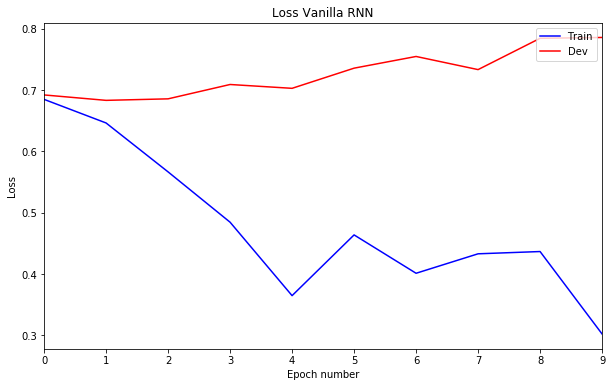

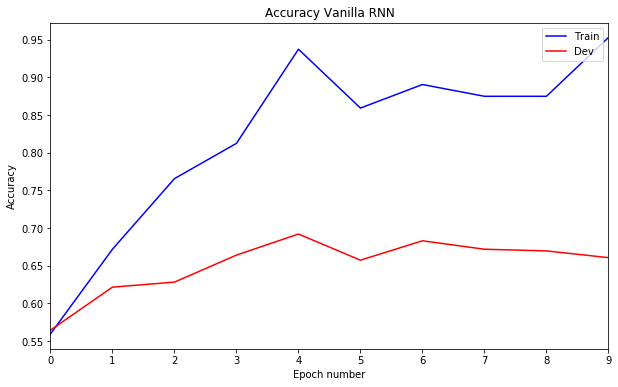

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(50,300,"lstm", 32,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 50)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:17:54.340479: step 10, loss 2.96676, acc 0.625
2019-10-26T04:17:55.002345: step 20, loss 1.50925, acc 0.609375
2019-10-26T04:17:55.635451: step 30, loss 0.9377, acc 0.53125
2019-10-26T04:17:56.316309: step 40, loss 0.735469, acc 0.640625
2019-10-26T04:17:56.968373: step 50, loss 0.649469, acc 0.828125
2019-10-26T04:17:57.628069: step 60, loss 0.639054, acc 0.75
2019-10-26T04:17:58.292245: step 70, loss 0.669398, acc 0.65625
2019-10-26T04:17:58.931837: step 80, loss 0.659966, acc 0.6875
2019-10-26T04:17:59.603740: step 90, loss 0.630585, acc 0.75
2019-10-26T04:18:00.237905: step 100, loss 0.639702, acc 0.703125

Evaluation:
2019-10-26T04:18:00.771914: step 106, loss 0.621919, acc 0.731243

2019-10-26T04:18:01.024975: step 110, loss 0.483401, acc 0.921875
2019-10-26T04:18:01.675676: step 120, loss 0.455151, acc 0.890625
2019-10-26T04:18:02.354066: step 130, loss 0.449245, acc 0.90625
2019-1

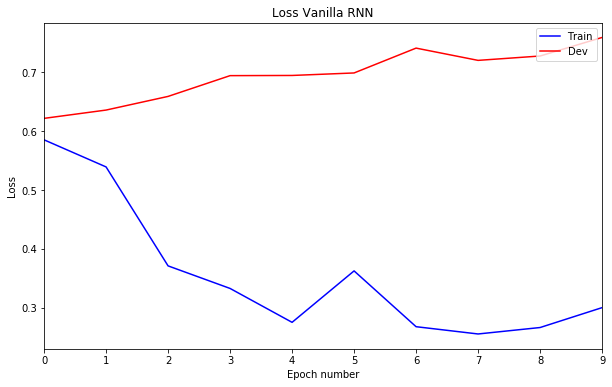

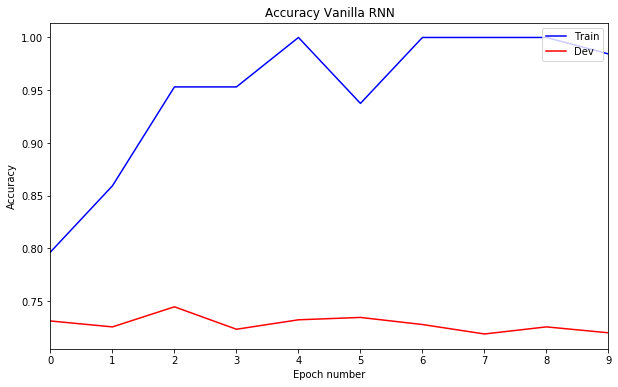

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(50,300,"gru", 32,3.0,1e-2, batch_size,0.5,epochs,glove)

Text Vocabulary Size: 16322
x = (9544, 50)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:19:10.845220: step 10, loss 3.4647, acc 0.53125
2019-10-26T04:19:11.531130: step 20, loss 1.77891, acc 0.546875
2019-10-26T04:19:12.171677: step 30, loss 1.05127, acc 0.5
2019-10-26T04:19:12.847476: step 40, loss 0.750428, acc 0.671875
2019-10-26T04:19:13.537742: step 50, loss 0.650694, acc 0.703125
2019-10-26T04:19:14.217757: step 60, loss 0.661272, acc 0.703125
2019-10-26T04:19:14.922509: step 70, loss 0.594059, acc 0.78125
2019-10-26T04:19:15.613938: step 80, loss 0.55894, acc 0.796875
2019-10-26T04:19:16.304836: step 90, loss 0.655635, acc 0.671875
2019-10-26T04:19:16.947953: step 100, loss 0.627233, acc 0.71875

Evaluation:
2019-10-26T04:19:17.502567: step 106, loss 0.583905, acc 0.75028

2019-10-26T04:19:17.759246: step 110, loss 0.397704, acc 0.953125
2019-10-26T04:19:18.432994: step 120, loss 0.431708, acc 0.859375
2019-10-26T04:19:19.114545: step 130, loss 0.44892, acc 0.9375
201

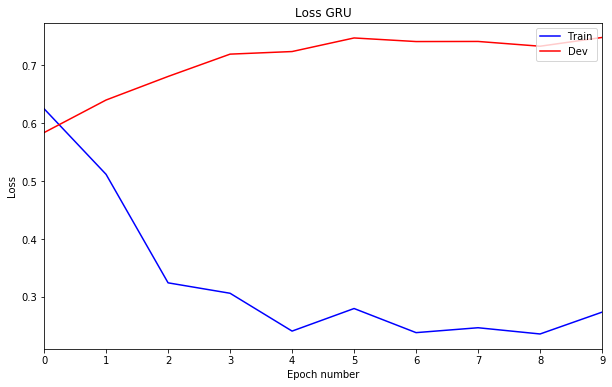

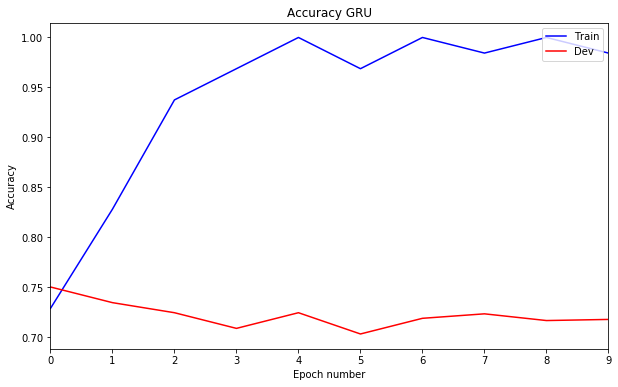

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss GRU')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy GRU')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

Using LSTM and Vanilla RNN for 50d and 100d glove vectors with 100 sentence length,

In [0]:
glove50=glove_embedding('glove.6B.50d.txt')

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,50,"lstm", 64,3.0,1e-2, batch_size,0.5,epochs,glove50)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:21:41.551939: step 10, loss 2.81123, acc 0.578125
2019-10-26T04:21:42.221767: step 20, loss 1.15651, acc 0.515625
2019-10-26T04:21:42.865279: step 30, loss 0.767945, acc 0.4375
2019-10-26T04:21:43.522215: step 40, loss 0.725364, acc 0.515625
2019-10-26T04:21:44.192569: step 50, loss 0.716422, acc 0.453125
2019-10-26T04:21:44.865111: step 60, loss 0.703583, acc 0.421875
2019-10-26T04:21:45.533311: step 70, loss 0.69824, acc 0.40625
2019-10-26T04:21:46.204643: step 80, loss 0.693536, acc 0.640625
2019-10-26T04:21:46.884572: step 90, loss 0.694329, acc 0.5625
2019-10-26T04:21:47.507453: step 100, loss 0.692847, acc 0.53125

Evaluation:
2019-10-26T04:21:48.037418: step 106, loss 0.694775, acc 0.487122

2019-10-26T04:21:48.298133: step 110, loss 0.693172, acc 0.5625
2019-10-26T04:21:48.975088: step 120, loss 0.69469, acc 0.4375
2019-10-26T04:21:49.642627: step 130, loss 0.695657, acc 0.484375

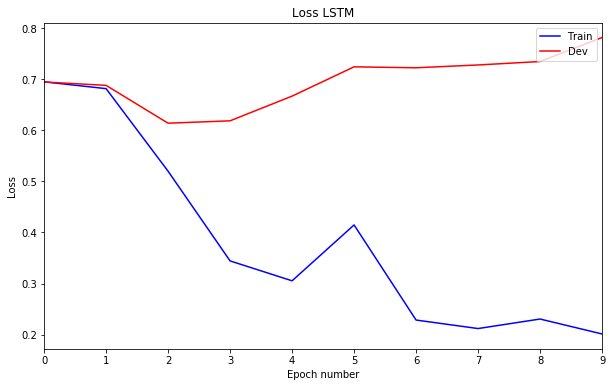

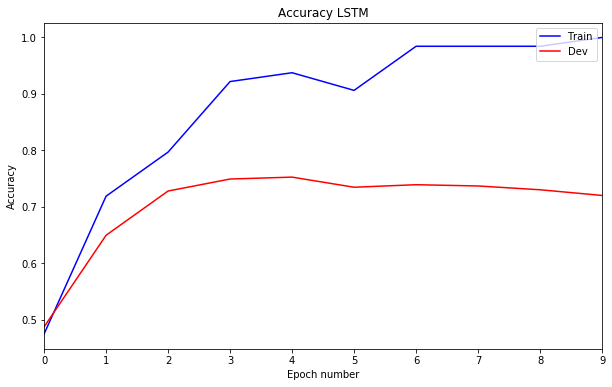

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss LSTM')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy LSTM')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,50,"vanilla", 64,3.0,1e-2, batch_size,0.5,epochs,glove50)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:23:30.332619: step 10, loss 2.84795, acc 0.5
2019-10-26T04:23:30.849532: step 20, loss 1.15255, acc 0.515625
2019-10-26T04:23:31.341546: step 30, loss 0.788493, acc 0.515625
2019-10-26T04:23:31.838634: step 40, loss 0.72623, acc 0.546875
2019-10-26T04:23:32.383489: step 50, loss 0.704889, acc 0.625
2019-10-26T04:23:32.884960: step 60, loss 0.697908, acc 0.609375
2019-10-26T04:23:33.396882: step 70, loss 0.703943, acc 0.453125
2019-10-26T04:23:33.904037: step 80, loss 0.699258, acc 0.53125
2019-10-26T04:23:34.416128: step 90, loss 0.70242, acc 0.515625
2019-10-26T04:23:34.898972: step 100, loss 0.707733, acc 0.53125

Evaluation:
2019-10-26T04:23:35.335468: step 106, loss 0.700114, acc 0.522956

2019-10-26T04:23:35.539923: step 110, loss 0.724667, acc 0.421875
2019-10-26T04:23:36.036250: step 120, loss 0.691413, acc 0.546875
2019-10-26T04:23:36.543927: step 130, loss 0.701236, acc 0.5625
2

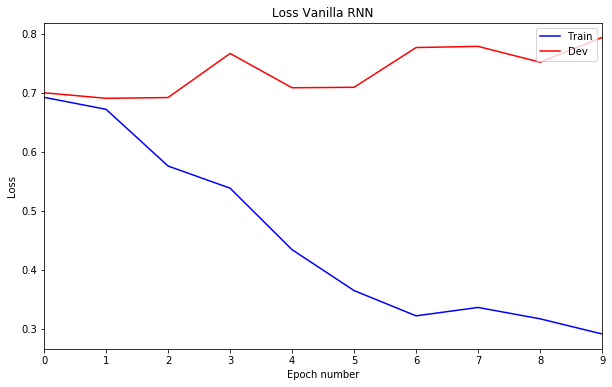

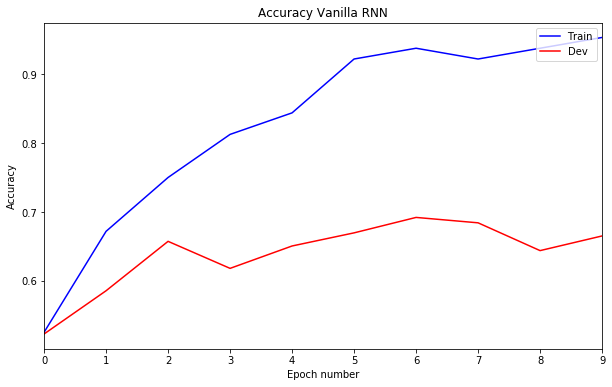

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
glove100=glove_embedding('glove.6B.100d.txt')

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,100,"vanilla", 64,3.0,1e-2, batch_size,0.5,epochs,glove100)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:25:21.873881: step 10, loss 2.74751, acc 0.453125
2019-10-26T04:25:22.402535: step 20, loss 1.10708, acc 0.5
2019-10-26T04:25:22.903723: step 30, loss 0.78122, acc 0.421875
2019-10-26T04:25:23.424639: step 40, loss 0.729025, acc 0.5625
2019-10-26T04:25:23.950729: step 50, loss 0.714693, acc 0.5
2019-10-26T04:25:24.463385: step 60, loss 0.704917, acc 0.46875
2019-10-26T04:25:24.992338: step 70, loss 0.698238, acc 0.53125
2019-10-26T04:25:25.515189: step 80, loss 0.689998, acc 0.5625
2019-10-26T04:25:26.047989: step 90, loss 0.696208, acc 0.515625
2019-10-26T04:25:26.533545: step 100, loss 0.712405, acc 0.53125

Evaluation:
2019-10-26T04:25:26.958179: step 106, loss 0.701299, acc 0.529675

2019-10-26T04:25:27.191108: step 110, loss 0.717709, acc 0.453125
2019-10-26T04:25:27.691135: step 120, loss 0.696635, acc 0.53125
2019-10-26T04:25:28.224299: step 130, loss 0.692143, acc 0.5625
2019-10-

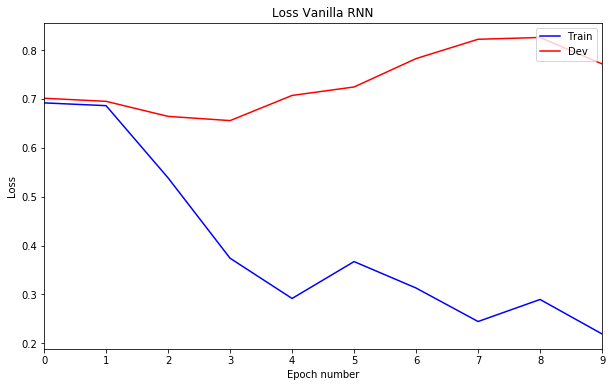

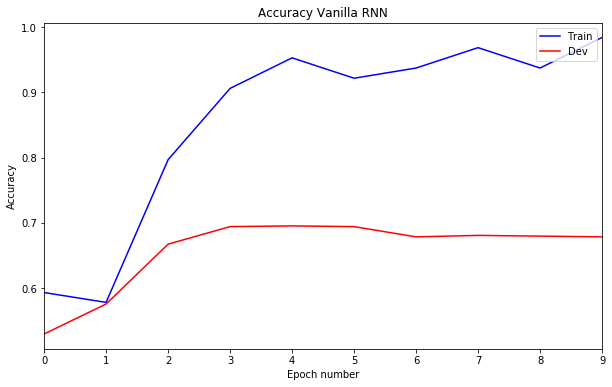

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy Vanilla RNN')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
loss_train, loss_dev, acc_train, acc_dev=train(100,100,"lstm", 64,3.0,1e-2, batch_size,0.5,epochs,glove100)

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

2019-10-26T04:26:53.110672: step 10, loss 2.84506, acc 0.40625
2019-10-26T04:26:53.801126: step 20, loss 1.1599, acc 0.484375
2019-10-26T04:26:54.455438: step 30, loss 0.771026, acc 0.515625
2019-10-26T04:26:55.116533: step 40, loss 0.728613, acc 0.5
2019-10-26T04:26:55.792510: step 50, loss 0.713857, acc 0.53125
2019-10-26T04:26:56.486346: step 60, loss 0.703575, acc 0.5
2019-10-26T04:26:57.152225: step 70, loss 0.702245, acc 0.421875
2019-10-26T04:26:57.828577: step 80, loss 0.688213, acc 0.65625
2019-10-26T04:26:58.520323: step 90, loss 0.693542, acc 0.515625
2019-10-26T04:26:59.157133: step 100, loss 0.692273, acc 0.53125

Evaluation:
2019-10-26T04:26:59.707957: step 106, loss 0.695704, acc 0.486002

2019-10-26T04:26:59.966424: step 110, loss 0.692098, acc 0.59375
2019-10-26T04:27:00.665643: step 120, loss 0.692401, acc 0.578125
2019-10-26T04:27:01.358106: step 130, loss 0.682776, acc 0.59375
2019

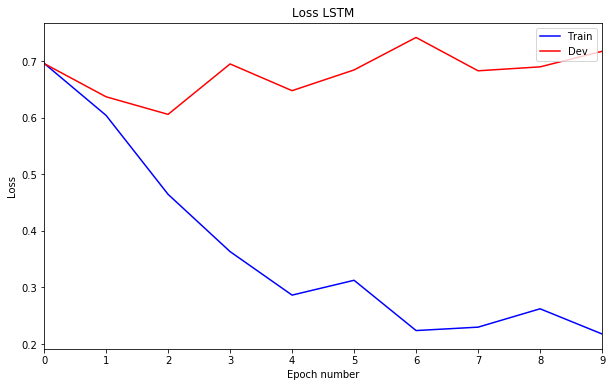

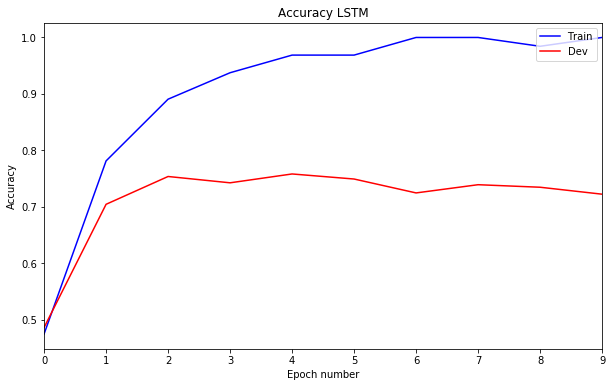

In [0]:
l_train=[]
a_train=[]
j=[i for i in range(int(train_size/batch_size),len(loss_train),int(train_size/batch_size))]
for i in j:
  l_train.append(loss_train[i])
  a_train.append(acc_train[i])
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),l_train,c='blue',label='Train')
plt.plot(range(len(loss_dev)),loss_dev,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss LSTM')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(j)),a_train,c='blue',label='Train')
plt.plot(range(len(acc_dev)),acc_dev,c='red',label='Dev')
plt.margins(x=0)
plt.legend(loc="upper right")
plt.title('Accuracy LSTM')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

Precision, Recall and F-score

In [0]:
def train1(max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs,glove):
  
  loss_train=[]
  acc_train=[]
  loss_dev=[]
  acc_dev=[]
  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
  for word, i in word_index.items():
      embedding_vector = glove.get(word)
      if embedding_vector is not None:
         
          embedding_matrix[i] = embedding_vector

  
  text_vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sentence_length)
  x = np.array(list(text_vocab_processor.fit_transform(x_text)))
  print("Text Vocabulary Size: {:d}".format(len(text_vocab_processor.vocabulary_)))

  print("x = {0}".format(x.shape))
  print("y = {0}".format(y.shape))
  print("")
  x_train, x_dev, y_train, y_dev,x_eval,y_eval=[],[],[],[],[],[]
  cnt=0
  np.random.seed(10)
  shuffle_indices = np.random.permutation(np.arange(len(y)))
  x_shuffled = x[shuffle_indices]
  y_shuffled = y[shuffle_indices]

  for key in split.keys():
    if split[key]==1:
      x_train.append(x_shuffled[cnt])
      y_train.append(y_shuffled[cnt])
    elif split[key]==3:
      x_dev.append(x_shuffled[cnt])
      y_dev.append(y_shuffled[cnt])
    else:
      x_eval.append(x_shuffled[cnt])
      y_eval.append(y_shuffled[cnt])
    cnt+=1
  x_train=np.array(x_train)
  x_dev=np.array(x_dev)
  y_train=np.array(y_train)
  y_dev=np.array(y_dev)
  x_eval=np.array(x_eval)
  y_eval=np.array(y_eval)

  print("Train/Dev split: {:d}/{:d}\n".format(len(y_train), len(y_dev)))
  recall, precision, fs=-1,-1,-1
  with tf.Graph().as_default():
      session_conf = tf.ConfigProto(
          allow_soft_placement=FLAGS.allow_soft_placement,
          log_device_placement=FLAGS.log_device_placement)
      sess = tf.Session(config=session_conf)
      with sess.as_default():
          rnn = RNN(
              sequence_length=x_train.shape[1],
              num_classes=y_train.shape[1],
              vocab_size=len(text_vocab_processor.vocabulary_),
              embedding_size=embedding_dim,
              cell_type=cell_type,
              hidden_size=hidden_size,
              l2_reg_lambda=l2_reg_lambda
          )

          # Define Training procedure
          global_step = tf.Variable(0, name="global_step", trainable=False)
          train_op = tf.train.AdamOptimizer(learning_rate).minimize(rnn.loss, global_step=global_step)
          loss_summary = tf.summary.scalar("loss", rnn.loss)
          acc_summary = tf.summary.scalar("accuracy", rnn.accuracy)
          train_summary_op = tf.summary.merge([loss_summary, acc_summary])
          
          # Initialize all variables
          sess.run(tf.global_variables_initializer())

          sess.run(rnn.W_text.assign(embedding_matrix))

          # Generate batches
          batches = batch_iter(
              list(zip(x_train, y_train)), batch_size, epochs)
          # Training loop. For each batch...
          for batch in batches:
              x_batch, y_batch = zip(*batch)
              # Train
              feed_dict = {
                  rnn.input_text: x_batch,
                  rnn.input_y: y_batch,
                  rnn.dropout_keep_prob: dropout
              }
              _, step, summaries, loss, accuracy = sess.run(
                  [train_op, global_step, train_summary_op, rnn.loss, rnn.accuracy], feed_dict)
              

              loss_train.append(loss)
              acc_train.append(accuracy)

              # Training log display
              if step % 10 == 0:
                  time_str = datetime.datetime.now().isoformat()
                  #print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))

              # Evaluation
              if step % int(train_size/batch_size) == 0:
                  #print("\nEvaluation:")
                  feed_dict_dev = {
                      rnn.input_text: x_dev,
                      rnn.input_y: y_dev,
                      rnn.dropout_keep_prob: dropout
                  }
                  dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
                  summaries_dev, loss, accuracy = sess.run(
                      [dev_summary_op, rnn.loss, rnn.accuracy], feed_dict_dev)
                  

                  time_str = datetime.datetime.now().isoformat()
                  
                  loss_dev.append(loss)
                  acc_dev.append(accuracy)
                  #print("{}: step {}, loss {:g}, acc {:g}\n".format(time_str, step, loss, accuracy))
                  
          for op in tf.get_default_graph().get_operations():
            #print(str(op.name))
            if str(op.name)=="input_text":
              input_text=op.outputs[0]
              print(input_text)
            elif str(op.name)=="dropout_keep_prob":
              dropout_keep_prob=op.outputs[0]
              print(dropout_keep_prob)
            elif str(op.name)=="output/predictions":
              predictions=op.outputs[0]
              print(predictions)
          batches = batch_iter(list(x_eval),batch_size, 1, shuffle=False)

          all_predictions=[]
          for x_batch in batches:
              batch_predictions = sess.run(predictions, {input_text: x_batch,
                                                         dropout_keep_prob: dropout})
              all_predictions = np.concatenate([all_predictions, batch_predictions])

          correct_predictions=0.0
          tp,tn,fp,fn=0,0,0,0
          for i in range(len(y_eval)):
            if y_eval[i][1]==1 and all_predictions[i]==1:
              tp+=1
            elif y_eval[i][1]==0 and all_predictions[i]==0:
              tn+=1
            elif y_eval[i][1]==1 and all_predictions[i]==0:
              fn+=1
            else:
              fp+=1
              
          
              
          print("Total number of test examples: {}".format(len(y_eval)))
          print("Accuracy: {:g}".format(correct_predictions / float(len(y_eval))))
  
  recall=tp/(tp+fn)
  precision=tp/(tp+fp)
  fs=(2*recall*precision)/(recall+precision)
  return precision, recall, fs




In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
precision, recall, fscore=train1(100,300,"vanilla", 64,3.0,1e-2, batch_size,0.5,epochs,glove)
print("Precision="+str(precision))
print("recall="+str(recall))
print("Fscore="+str(fscore))

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

Tensor("input_text:0", shape=(?, 100), dtype=int32)
Tensor("dropout_keep_prob:0", dtype=float32)
Tensor("output/predictions:0", shape=(?,), dtype=int64)
Total number of test examples: 1808
Accuracy: 0
Precision=0.6784565916398714
recall=0.697136563876652
Fscore=0.6876697447039651


In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
precision, recall, fscore=train1(100,300,"lstm", 64,3.0,1e-2, batch_size,0.5,epochs,glove)
print("Precision="+str(precision))
print("recall="+str(recall))
print("Fscore="+str(fscore))

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

Tensor("input_text:0", shape=(?, 100), dtype=int32)
Tensor("dropout_keep_prob:0", dtype=float32)
Tensor("output/predictions:0", shape=(?,), dtype=int64)
Total number of test examples: 1808
Accuracy: 0
Precision=0.7427912341407151
recall=0.7092511013215859
Fscore=0.7256338028169014


In [0]:
train_size=6843
batch_size=64
epochs=10
#Hyperparameters: max_sentence_length, embedding_dim, cell_type, hidden_size, l2_reg_lambda, learning_rate, batch_size, dropout,epochs
precision, recall, fscore=train1(100,300,"gru", 64,3.0,1e-2, batch_size,0.5,epochs,glove)
print("Precision="+str(precision))
print("recall="+str(recall))
print("Fscore="+str(fscore))

Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)

Train/Dev split: 6843/893

Tensor("input_text:0", shape=(?, 100), dtype=int32)
Tensor("dropout_keep_prob:0", dtype=float32)
Tensor("output/predictions:0", shape=(?,), dtype=int64)
Total number of test examples: 1808
Accuracy: 0
Precision=0.7520858164481525
recall=0.6949339207048458
Fscore=0.7223812249570692


Question 3.2: The networks seem to be robust to changes in hidden units, sequence length, and dimensionality of the word embeddings. Best performance results in optimal time is given my LSTM. GRU also giving similar performance results. Vanilla RNN consistently gives the worst performance amongst all 3 networks for any combination of hyperparameters in comparison to LSTM and GRU.

Question 3.3: LSTM gives the best performance amongst all 3 architectures on test data. Vanilla RNN consistently gives the worst performance amongst all 3 architectures for any combination of hyperparameters. GRU gives similar performance to LSTM but is more time consuming.